# Fashion-MNIST Classification using ResNet

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import math
import torch.nn.functional as F
import torch.nn.init as init
from tqdm import tqdm
import os

from model import ResNet, BasicBlock
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

In [ ]:
config = {
    'batch_size': 512,
    'lr': 0.001,
    'epochs': 30,
    'checkpoint_dir': "./checkpoint"
}

os.makedirs(config['checkpoint_dir'], exist_ok=True)

In [3]:
# Download training and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform_train)
val_dataset = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform_test)


# prepare dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=128,
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=128,
)


In [4]:
print("train dataloader: ", train_dataloader.__len__())
print("val dataloader: ", val_dataloader.__len__())

train dataloader:  118
val dataloader:  20


torch.Size([1, 28, 28]) torch.Size([512])
Shirt


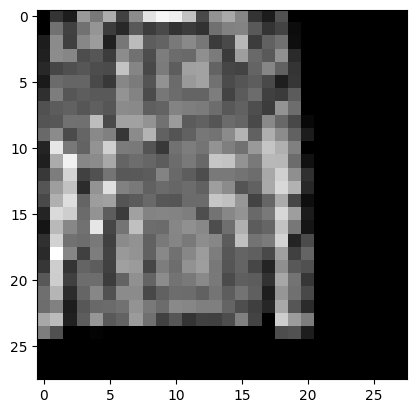

In [5]:
image, label = next(iter(train_dataloader))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray')

## Build the network

In [ ]:
torch.backends.cudnn.deterministic = True
model = ResNet(BasicBlock, [2, 2, 2])
if torch.cuda.is_available():
    DEVICE = "cuda"
    model = model.to(DEVICE)
    n = torch.cuda.device_count()
    if n > 1:
        model = nn.DataParallel(model)
else:
    DEVICE = "cpu"

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config["epochs"], eta_min=1e-5)
scaler = torch.amp.GradScaler()

In [8]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

## Train the network

In [9]:
def train_epoch(model, dataloader, optimizer, criterion, scaler):
    model.train()
    
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    for _, (images, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.autocast(device_type = 'cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_m.update(loss.item(), images.size(0))
        acc = accuracy(outputs, labels)[0].item()
        acc_m.update(acc, images.size(0))
        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        batch_bar.update() # Update tqdm bar
        
    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [10]:
@torch.no_grad()
def valid_epoch(model, dataloader):
    model.eval()
    
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # metrics
        acc = accuracy(outputs, labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg))

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [11]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    if torch.cuda.device_count() > 1:
        torch.save(
            {'model_state_dict'         : model.module.state_dict(),
             'optimizer_state_dict'     : optimizer.state_dict(),
             'scheduler_state_dict'     : scheduler.state_dict(),
             'metric'                   : metrics,
             'epoch'                    : epoch},
             path)
    else:
        torch.save(
            {'model_state_dict'        : model.state_dict(),
            'optimizer_state_dict'     : optimizer.state_dict(),
            'scheduler_state_dict'     : scheduler.state_dict(),
            'metric'                   : metrics,
            'epoch'                    : epoch},
            path)

In [12]:
best_valid_acc = 0.0
for epoch in range(config['epochs']):
    # epoch
    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    # train
    train_acc, train_loss = train_epoch(model, train_dataloader, optimizer, criterion, scaler)
    curr_lr = float(optimizer.param_groups[0]['lr'])
    print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))
    metrics = {
        'train_acc': train_acc,
        'train_loss': train_loss,
    }

    # classification validation
    valid_acc, valid_loss = valid_epoch(model, val_dataloader)
    print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_acc, valid_loss))
    metrics.update({
        'valid_cls_acc': valid_acc,
        'valid_loss': valid_loss,
    })

    # save model
    save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
    print("Saved epoch model")

    # save best model
    if valid_acc >= best_valid_acc:
        best_valid_acc = valid_acc
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best.pth'))
        print("Saved best classification model")
    
    # scheduler step
    scheduler.step()



Epoch 1/30



Epoch 1/30: 
Train Cls. Acc 78.5450%	 Train Cls. Loss 0.8257	 Learning Rate 0.0010


Val Cls. Acc 84.0148%	 Val Cls. Loss 0.6290
Saved epoch model
Saved best classification model

Epoch 2/30



Epoch 2/30: 
Train Cls. Acc 86.9983%	 Train Cls. Loss 0.5463	 Learning Rate 0.0010


Val Cls. Acc 85.9243%	 Val Cls. Loss 0.6005
Saved epoch model
Saved best classification model

Epoch 3/30



Epoch 3/30: 
Train Cls. Acc 89.1650%	 Train Cls. Loss 0.4475	 Learning Rate 0.0010


Val Cls. Acc 86.0656%	 Val Cls. Loss 0.5128
Saved epoch model
Saved best classification model

Epoch 4/30



Epoch 4/30: 
Train Cls. Acc 90.3033%	 Train Cls. Loss 0.3875	 Learning Rate 0.0010


Val Cls. Acc 87.7327%	 Val Cls. Loss 0.4476
Saved epoch model
Saved best classification model

Epoch 5/30



Epoch 5/30: 
Train Cls. Acc 90.8967%	 Train Cls. Loss 0.3479	 Learning Rate 0.0010


Val Cls. Acc 89.6283%	 Val Cls. Loss 0.3695
Saved epoch model
Saved best classification model

Epoch 6/30



Epoch 6/30: 
Train Cls. Acc 91.5283%	 Train Cls. Loss 0.3143	 Learning Rate 0.0009


Val Cls. Acc 80.5032%	 Val Cls. Loss 0.6076
Saved epoch model

Epoch 7/30



Epoch 7/30: 
Train Cls. Acc 91.7900%	 Train Cls. Loss 0.2963	 Learning Rate 0.0009


Val Cls. Acc 90.1545%	 Val Cls. Loss 0.3333
Saved epoch model
Saved best classification model

Epoch 8/30



Epoch 8/30: 
Train Cls. Acc 92.3633%	 Train Cls. Loss 0.2748	 Learning Rate 0.0009


Val Cls. Acc 90.9605%	 Val Cls. Loss 0.3005
Saved epoch model
Saved best classification model

Epoch 9/30



Epoch 9/30: 
Train Cls. Acc 92.6217%	 Train Cls. Loss 0.2606	 Learning Rate 0.0008


Val Cls. Acc 90.4756%	 Val Cls. Loss 0.3166
Saved epoch model

Epoch 10/30



Epoch 10/30: 
Train Cls. Acc 92.8267%	 Train Cls. Loss 0.2473	 Learning Rate 0.0008


Val Cls. Acc 91.4137%	 Val Cls. Loss 0.2838
Saved epoch model
Saved best classification model

Epoch 11/30



Epoch 11/30: 
Train Cls. Acc 93.0483%	 Train Cls. Loss 0.2337	 Learning Rate 0.0008


Val Cls. Acc 91.8503%	 Val Cls. Loss 0.2834
Saved epoch model
Saved best classification model

Epoch 12/30



Epoch 12/30: 
Train Cls. Acc 93.4583%	 Train Cls. Loss 0.2221	 Learning Rate 0.0007


Val Cls. Acc 92.4167%	 Val Cls. Loss 0.2431
Saved epoch model
Saved best classification model

Epoch 13/30



Epoch 13/30: 
Train Cls. Acc 93.8200%	 Train Cls. Loss 0.2089	 Learning Rate 0.0007


Val Cls. Acc 92.7660%	 Val Cls. Loss 0.2261
Saved epoch model
Saved best classification model

Epoch 14/30



Epoch 14/30: 
Train Cls. Acc 93.9367%	 Train Cls. Loss 0.2013	 Learning Rate 0.0006


Val Cls. Acc 92.9688%	 Val Cls. Loss 0.2150
Saved epoch model
Saved best classification model

Epoch 15/30



Epoch 15/30: 
Train Cls. Acc 94.2100%	 Train Cls. Loss 0.1925	 Learning Rate 0.0006


Val Cls. Acc 93.5352%	 Val Cls. Loss 0.2121
Saved epoch model
Saved best classification model

Epoch 16/30



Epoch 16/30: 
Train Cls. Acc 94.4650%	 Train Cls. Loss 0.1840	 Learning Rate 0.0005


Val Cls. Acc 93.1738%	 Val Cls. Loss 0.2165
Saved epoch model

Epoch 17/30



Epoch 17/30: 
Train Cls. Acc 94.7967%	 Train Cls. Loss 0.1742	 Learning Rate 0.0005


Val Cls. Acc 92.7148%	 Val Cls. Loss 0.2352
Saved epoch model

Epoch 18/30



Epoch 18/30: 
Train Cls. Acc 95.0317%	 Train Cls. Loss 0.1668	 Learning Rate 0.0004


Val Cls. Acc 93.8942%	 Val Cls. Loss 0.1953
Saved epoch model
Saved best classification model

Epoch 19/30



Epoch 19/30: 
Train Cls. Acc 95.2567%	 Train Cls. Loss 0.1582	 Learning Rate 0.0004


Val Cls. Acc 93.3680%	 Val Cls. Loss 0.2142
Saved epoch model

Epoch 20/30



Epoch 20/30: 
Train Cls. Acc 95.6517%	 Train Cls. Loss 0.1484	 Learning Rate 0.0003


Val Cls. Acc 94.3153%	 Val Cls. Loss 0.1854
Saved epoch model
Saved best classification model

Epoch 21/30



Epoch 21/30: 
Train Cls. Acc 95.8983%	 Train Cls. Loss 0.1403	 Learning Rate 0.0003


Val Cls. Acc 94.0774%	 Val Cls. Loss 0.1883
Saved epoch model

Epoch 22/30



Epoch 22/30: 
Train Cls. Acc 95.8717%	 Train Cls. Loss 0.1395	 Learning Rate 0.0002


Val Cls. Acc 94.0929%	 Val Cls. Loss 0.1860
Saved epoch model

Epoch 23/30



Epoch 23/30: 
Train Cls. Acc 96.3983%	 Train Cls. Loss 0.1245	 Learning Rate 0.0002


Val Cls. Acc 94.6375%	 Val Cls. Loss 0.1797
Saved epoch model
Saved best classification model

Epoch 24/30



Epoch 24/30: 
Train Cls. Acc 96.6950%	 Train Cls. Loss 0.1176	 Learning Rate 0.0001


Val Cls. Acc 94.8328%	 Val Cls. Loss 0.1750
Saved epoch model
Saved best classification model

Epoch 25/30



Epoch 25/30: 
Train Cls. Acc 96.9867%	 Train Cls. Loss 0.1093	 Learning Rate 0.0001


Val Cls. Acc 94.6559%	 Val Cls. Loss 0.1791
Saved epoch model

Epoch 26/30



Epoch 26/30: 
Train Cls. Acc 97.2550%	 Train Cls. Loss 0.1031	 Learning Rate 0.0001


Val Cls. Acc 94.7633%	 Val Cls. Loss 0.1748
Saved epoch model

Epoch 27/30



Epoch 27/30: 
Train Cls. Acc 97.4767%	 Train Cls. Loss 0.0967	 Learning Rate 0.0001


Val Cls. Acc 94.7719%	 Val Cls. Loss 0.1752
Saved epoch model

Epoch 28/30



Epoch 28/30: 
Train Cls. Acc 97.5950%	 Train Cls. Loss 0.0922	 Learning Rate 0.0000


Val Cls. Acc 94.7731%	 Val Cls. Loss 0.1750
Saved epoch model

Epoch 29/30



Epoch 29/30: 
Train Cls. Acc 97.6917%	 Train Cls. Loss 0.0902	 Learning Rate 0.0000


Val Cls. Acc 94.8621%	 Val Cls. Loss 0.1727
Saved epoch model
Saved best classification model

Epoch 30/30



Epoch 30/30: 
Train Cls. Acc 97.7717%	 Train Cls. Loss 0.0878	 Learning Rate 0.0000


Val Cls. Acc 94.8305%	 Val Cls. Loss 0.1763
Saved epoch model
